In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from numba import njit, prange

In [2]:
def add_noise(img, sigma):

    noise = np.random.normal(0, sigma, img.shape).astype(np.uint8)
    img += noise
    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX, dtype=-1)


def gen_circle(radius, nb_circles, img_shape):

    int_rad = np.ceil(radius)
    m, n = img_shape
    img = np.zeros(img_shape, dtype=np.uint8)

    if nb_circles == 1:
        x_c, y_c = m//2, n//2
        img = cv2.circle(img, (x_c, y_c), radius, [255, 255, 255], thickness=3)
    else:
        for _ in range(nb_circles):
            x_c = np.random.randint(int_rad, m - int_rad, dtype=np.int)
            y_c = np.random.randint(int_rad, n - int_rad, dtype=np.int)
            img = cv2.circle(img, (x_c, y_c), radius, [255, 255, 255], thickness=3)
    return img


def processImage(src, cannyLowThresh = 80, cannyHighThresh = 100):

    edges = cv2.Canny(src, cannyLowThresh, cannyHighThresh)
    x, y = np.nonzero(edges)

    dx = cv2.Sobel(src, cv2.CV_64F, 1, 0)
    dy = cv2.Sobel(src, cv2.CV_64F, 0, 1)
    angles = np.degrees(np.arctan2(dy, dx)).astype(np.int16)

    return x, y, angles[x, y]


def processTmpl(tmpl, ref_pt):
    """TODO: Create function to find center of mass for refPoint"""""
    m, n = tmpl.shape

    if ref_pt == (-1, -1):
        ref_pt = (m//2, n//2)

    x, y, phi = processImage(tmpl)

    calcDist(x, y, ref_pt)
    return x, y, phi


def processQuery(query, blur, sigma):

    if blur:
        query = cv2.GaussianBlur(query, (sigma, sigma), 0)

    x, y, phi = processImage(query)
    return x, y, phi


@njit
def increment(accum, indices, vec_x, vec_y):

    for i in indices:
        x, y = vec_x[i], vec_y[i]
        accum[x, y] += 1


def calcDist(x, y, ref_pt):

    x -= ref_pt[0]
    y -= ref_pt[1]


@njit
def pad(src, size):
    m, n = src.shape
    dst = np.zeros((m + 2 * size, n + 2 * size), dtype=np.uint8)
    dst[size:m + size, size:n + size] = src
    return dst

In [3]:
@njit
def build_table(x, y, phi):
    r_table = {}
    for theta in prange(-180, 180, 1):
        indices = np.flatnonzero(phi == theta)
        if indices.any():
            r_table[theta] = np.vstack((x[indices], y[indices])).T
    return r_table


@njit
def build_accum(x, y, phi, r_table, shape):
    m, n = shape
    accum = np.zeros(shape, dtype=np.int64)

    for angle in r_table:
        entries = r_table[angle]
        sz = entries.shape[0]
        indices = np.flatnonzero(phi == angle)

        for i in range(sz):
            dx, dy = entries[i][0], entries[i][1]
            x_cand, y_cand = x[indices] + dx, y[indices] + dy
            cond = (0 <= x_cand) * (x_cand < m) * (0 <= y_cand) * (y_cand < n)
            valid_indices = np.flatnonzero(cond)
            increment(accum, valid_indices, x_cand, y_cand)

    return accum


@njit
def find_maximas(src, grid_size):
    padded_src = pad(src, grid_size)
    x_maxs, y_maxs, values = [], [], []
    I, J = np.nonzero(padded_src)
    for i in range(len(I)):
        x, y = I[i], J[i]
        value = padded_src[x, y]

        grid = np.copy(padded_src[x-grid_size:x+grid_size+1, y-grid_size:y+grid_size + 1])
        grid[grid_size, grid_size] = 0

        if np.all(value >= grid):
            x -= grid_size
            y -= grid_size
            x_maxs.append(x)
            y_maxs.append(y)
            values.append(value)
    return x_maxs, y_maxs, values


@njit
def threshold_accum(src, factor=1):
    nb_pixels = len(np.nonzero(src)[0])
    thresh_value = factor * np.sum(src) // nb_pixels
    src = np.where(src > thresh_value, src, 0)
    return src

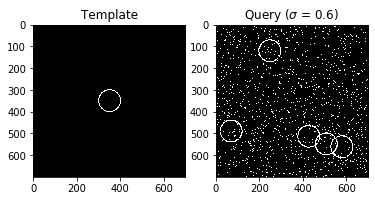

In [4]:
radius = 50
shape = (700, 700)
noise_level = 0.6
nb_circles = 5

tmpl = gen_circle(radius, 1, shape)
query = gen_circle(radius, nb_circles, shape)
add_noise(query, noise_level)

plt.subplot(1, 2, 1)
plt.title('Template')
plt.imshow(tmpl, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Query ($\sigma$ = ' + str(noise_level) + ')')
plt.imshow(query, cmap='gray')

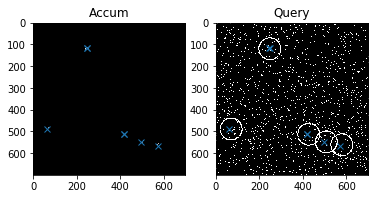

In [5]:
I, J, Phi = processTmpl(tmpl, (-1, -1))
R_Table = build_table(I, J, Phi)

I, J, Phi = processQuery(query, False, 3)
Accum = build_accum(I, J, Phi, R_Table, shape)
Accum = threshold_accum(Accum, 4.5)

x_m, y_m, v_m = find_maximas(Accum, 15)

plt.subplot(1, 2, 1)
plt.title('Accum')
plt.imshow(Accum, cmap='gray')
plt.plot(y_m, x_m, 'x')

plt.subplot(1, 2, 2)
plt.title('Query')
plt.imshow(query, cmap='gray')
plt.plot(y_m, x_m, 'x')

In [6]:
@njit(parallel=True, cache=True)
def cast_to_int(M):
    m, n = M.shape
    N = np.empty_like(M, dtype=np.int64)
    for i in prange(m):
        for j in prange(n):
            N[i, j] = int(np.round(M[i, j]))
    return N


def gen_circle(radius, nb_circles, img_shape):
    
    radius4 = np.ceil(radius)
    rad_range = (0.4 * radius, 2 * radius)
    m, n = img_shape
    img = np.zeros(img_shape, dtype=np.uint8)

    if nb_circles == 1:
        x_c, y_c = m//2, n//2
        img = cv2.circle(img, (x_c, y_c), radius, [255, 255, 255], thickness=3)
    else:
        for _ in range(nb_circles):
            radius = np.random.randint(rad_range[0], rad_range[1], dtype=np.int)
            x_c = np.random.randint(radius, m - radius, dtype=np.int)
            y_c = np.random.randint(radius, n - radius, dtype=np.int)
            img = cv2.circle(img, (x_c, y_c), radius, [255, 255, 255], thickness=3)
    return img

In [7]:
@njit
def scale_matrix(M, scale):
    M = M.astype(np.float64) * scale
    return cast_to_int(M)


@njit
def scale_table(table, scale):
    new_table = {}
    for phi in table:
        new_table[phi] = scale_matrix(table[phi], scale)
    return new_table

@njit
def build_all_accums(pos_x, pos_y, pos_phi, table, shape, thresh = 3, grid_size=10):
    I, J, M = [], [], []
    for s in np.arange(0.2, 5, 0.02):
        new_table = scale_table(table, s)
        new_acc = build_accum(pos_x, pos_y, pos_phi, new_table, shape)
        new_acc = threshold_accum(new_acc, thresh)
        x, y, values = find_maximas(new_acc, 10)
        if x:
            I.append(x)
            J.append(y)
            M.append(values)
    return I, J, M

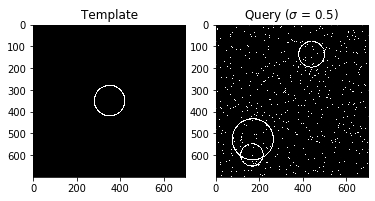

In [8]:
radius = 70
shape = (700, 700)
noise_level = 0.5
nb_circles = 3

tmpl = gen_circle(radius, 1, shape)
query = gen_circle(radius, nb_circles, shape)
add_noise(query, noise_level)

plt.subplot(1, 2, 1)
plt.title('Template')
plt.imshow(tmpl, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Query ($\sigma$ = ' + str(noise_level) + ')')
plt.imshow(query, cmap='gray')

In [9]:
I, J, Phi = processTmpl(tmpl, (-1, -1))
R_Table = build_table(I, J, Phi)

I, J, Phi = processQuery(query, False, 3)

X, Y, V = build_all_accums(I, J, Phi, R_Table, shape, 3, 25)
X = np.concatenate([np.array(i) for i in X])
Y = np.concatenate([np.array(i) for i in Y])
V = np.concatenate([np.array(i) for i in V])

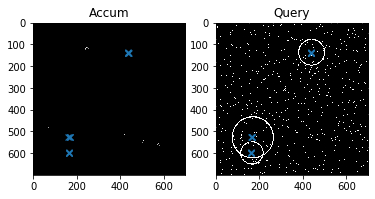

In [10]:
V = V / np.max(V)
thresh = 0.5

x_m, y_m = X[V > thresh], Y[V > thresh]

plt.subplot(1, 2, 1)
plt.title('Accum')
plt.imshow(Accum, cmap='gray')
plt.plot(y_m, x_m, 'x')

plt.subplot(1, 2, 2)
plt.title('Query')
plt.imshow(query, cmap='gray')
plt.plot(y_m, x_m, 'x')